<a href="https://colab.research.google.com/github/funteck123/SUSAR_AI_Framework_Insight_Classfication_with_LLM_Text_Gen_Model-Python/blob/main/SUSAR_AI_Framework_Insight_Classfication_with_LLM_Text_Gen_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SUSAR AI Framework - Insight Classfication with LLM Text Gen Model** 🧠📔


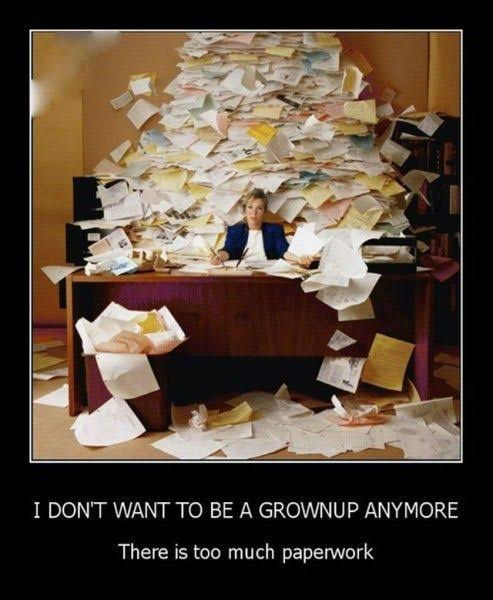


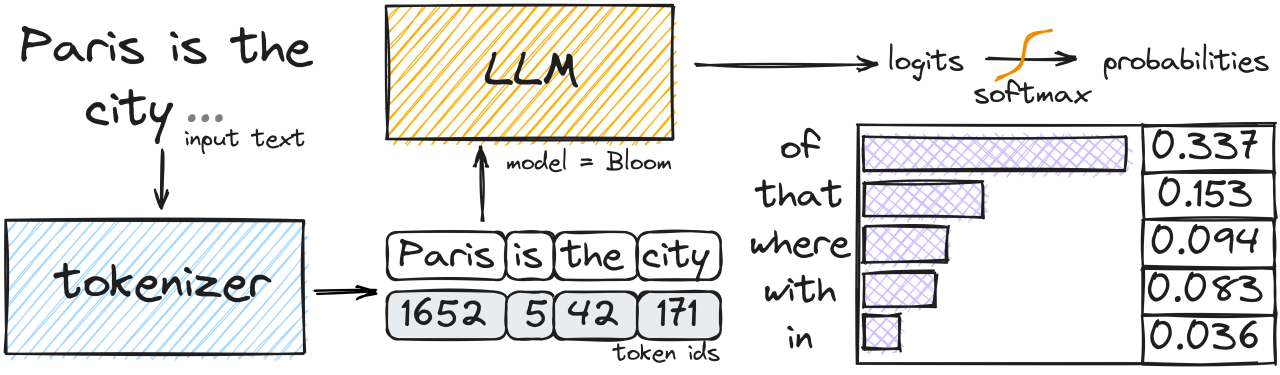

In [1]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-6y58pwof/unsloth_f0ac6645825a4b2fb02c51da79439655
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-6y58pwof/unsloth_f0ac6645825a4b2fb02c51da79439655
  Resolved https://github.com/unslothai/unsloth.git to commit 4e570be9ae4ced8cdc64e498125708e34942befc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 8.9 MB/s eta 0:00:00
   ━━━

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import re
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [12]:
# Define model parameters
max_seq_length = 2048  # Adjust as needed
dtype = None  # Automatic detection of data type
load_in_4bit = True  # Use 4-bit quantization to save memory

# Load the Llama-3 model
# model_name = "unsloth/llama-3-8b-bnb-4bit"
# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name=model_name,
#     max_seq_length=max_seq_length,
#     dtype=dtype,
#     load_in_4bit=load_in_4bit
# )

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

# Create a text generation pipeline with GPU support
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)



==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [7]:
# Patient Outcomes
patient_outcome_texts = [
    "The patient's clinical status shows incremental improvement with stable vital signs; however, full recovery remains elusive as evidenced by residual chronic symptoms and ongoing need for symptomatic treatment.",
    "Despite progressive therapeutic interventions, the patient exhibits persistent adverse reactions and secondary complications that impede recovery, necessitating advanced management strategies.",
    "Following an initial positive response to therapy, the patient has reached a plateau in health status with complete resolution of acute symptoms but ongoing subclinical indicators suggesting the necessity for prolonged observation.",
    "The patient's health trajectory demonstrates significant amelioration with the resolution of major disease symptoms, although minor residual effects warrant continued follow-up to confirm sustained recovery." ,
    "The patient's condition, initially responsive to treatment, has deteriorated leading to multi-organ failure, resulting in a deadly outcome."
]

# Correct outputs corresponding to the texts
patient_outcome_labels = [
    "Recovering",               # Incremental improvement but full recovery remains elusive
    "Not Recovering",  # Persistent adverse reactions and secondary complications impede recovery
    "Recovering",               # Plateau in health status with ongoing subclinical indicators
    "Recovering",               # Significant amelioration with resolution of major symptoms, minor residual effects
    "Fatal"                    # Deterioration leading to multi-organ failure and a deadly outcome
]


# Drug Actions
drug_action_texts = [
    "The dosage of the current medication was maintained following an assessment indicating stable clinical progress and minimal adverse events. Future evaluations will continue to monitor the necessity of any further dosage adjustments based on patient response.",
    "The patient's recent adverse events are attributable to excessive drug exposure, prompting a dose reduction to mitigate toxicity while maintaining therapeutic benefits.",
    "Current therapeutic levels have stabilized the patient's condition; hence, no modification to the dosage is required as the medication remains within the therapeutic window.",
    "Due to the onset of severe side effects consistent with drug overdose, the medication regimen has been temporarily halted pending reassessment and dose adjustment.",
    "Emerging evidence from recent trials supports an escalation of the drug dosage to enhance therapeutic outcomes, with close monitoring for potential adverse effects during the increased dosage phase."
]

drug_action_labels = [
    "Same Dose",
    "Decrease",
    "Same Dose",
    "Stop",
    "Increase"
]

# Causalities
causality_texts = [
    "Analysis of the patient's symptomatology indicates that the observed side effects are consistent with known adverse reactions to the current medication, suggesting a direct causal relationship.",
    "The patient's clinical presentation correlates with a new, unrelated health condition, with no evidence linking the symptoms to the ongoing pharmacological treatment.",
    "The documented adverse effects are attributable to an interaction between the drug and an external factor, rather than a direct consequence of the medication itself.",
    "In-depth diagnostic evaluations reveal that the recent health complications are a direct result of the pharmacological intervention, corroborating a causative link between the drug and the symptoms.",
    "The occurrence of unexpected side effects aligns with a known complication profile for the drug, indicating that the medication is likely the primary factor contributing to the patient's symptoms."
]

causality_labels = [
    "Related",
    "Not Related",
    "Not Related",
    "Related",
    "Related"
]


In [10]:
# Define normalization function
def normalize_text(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def normalize_text_array(text_array):
  for i in range(len(text_array)):
    text_array[i] = normalize_text(text_array[i])

  return text_array

# Initialize global variables for predictions
patient_outcomes_pred = []
drug_actions_pred = []
causalities_pred = []

# Function to evaluate patient outcomes
def evaluate_patient_outcomes(texts, correct_outputs):
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        prompt = f"""
        You are provided with a description of a patient's health status. Your task is to classify the health status into one of the following categories based on the description provided:

        - Not Recovering: The patient is not showing signs of improvement and is not progressing towards recovery.
        - Recovering: The patient is in the process of improvement but has not yet fully recovered to a normal health state.
        - Recovering with Complications: The patient is in the recovery phase but is experiencing additional complications or health issues.
        - Recovered: The patient has fully recovered and returned to their normal state of health with negligible ongoing issues.
        - Fatal: The patient has passed away due to the condition or treatment.

        Description: {text}

        Based on the description, please assign the most appropriate label from the options: [Not Recovering, Recovering, Recovering with Complications, Recovered, Fatal]
        Label:
        """
        result = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        generated_text = normalize_text(result[0]['generated_text'])
        patient_outcomes_pred.append(generated_text)

        correct_output = normalize_text(correct_outputs[i])
        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Patient Outcome Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

# Function to evaluate drug actions
def evaluate_drug_actions(texts, correct_outputs):
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        prompt = f"""
        Based on the description provided, identify the appropriate action related to the dosage of the drug. Choose one of the following options: Same Dose, Stop, Increase, Decrease

        Description: {text}

        Label:
        """
        result = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        generated_text = normalize_text(result[0]['generated_text'])
        drug_actions_pred.append(generated_text)

        correct_output = normalize_text(correct_outputs[i])
        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Drug Action Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

# Function to evaluate causalities
def evaluate_causalities(texts, correct_outputs):
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        prompt = f"""
        Based on the provided text, determine if the observed symptoms or issues are related to the drug treatment or not. Choose one of the following options:

        - Related: The symptoms or issues are connected to the drug or treatment.
        - Not Related: The symptoms or issues are not connected to the drug or treatment and may be due to other factors.

        Description: {text}

        Assign the correct causality label from the options: [Related, Not Related]
        Label:
        """
        result = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        generated_text = normalize_text(result[0]['generated_text'])
        causalities_pred.append(generated_text)

        correct_output = normalize_text(correct_outputs[i])
        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Causality Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy


In [11]:
# Evaluate the model
patient_outcome_accuracy = evaluate_patient_outcomes(patient_outcome_texts, patient_outcome_labels)
print(f"Patient Outcome Accuracy: {patient_outcome_accuracy:.2f}%")

drug_action_accuracy = evaluate_drug_actions(drug_action_texts, drug_action_labels)
print(f"Drug Action Accuracy: {drug_action_accuracy:.2f}%")

causality_accuracy = evaluate_causalities(causality_texts, causality_labels)
print(f"Causality Accuracy: {causality_accuracy:.2f}%")

KeyError: 'Cache only has 0 layers, attempted to access layer with index 0'

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
categories = ['Patient Outcomes', 'Drug Actions', 'Causalities']
accuracies = [patient_outcome_accuracy, drug_action_accuracy, causality_accuracy]  # Replace with actual accuracy values if different

# Plot
plt.figure(figsize=(10, 6))
plt.bar(categories, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Categories')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Category')
plt.ylim(0, 110)
plt.grid(axis='y')
plt.show()


In [ ]:
patient_outcome_labels = normalize_text_array(patient_outcome_labels)


drug_action_labels = normalize_text_array(drug_action_labels)


causality_labels = normalize_text_array(causality_labels)

# Compute confusion matrices
conf_matrix_patient_outcomes = confusion_matrix(patient_outcome_labels, patient_outcomes_pred)
conf_matrix_drug_actions = confusion_matrix(drug_action_labels, drug_actions_pred)
conf_matrix_causalities = confusion_matrix(causality_labels, causalities_pred)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot confusion matrix for Patient Outcomes
sns.heatmap(conf_matrix_patient_outcomes, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal'],
            yticklabels=['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal'],
            ax=axs[0])
axs[0].set_title('Confusion Matrix for Patient Outcomes')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

# Plot confusion matrix for Drug Actions
sns.heatmap(conf_matrix_drug_actions, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Same Dose', 'Stop', 'Increase', 'Decrease'],
            yticklabels=['Same Dose', 'Stop', 'Increase', 'Decrease'],
            ax=axs[1])
axs[1].set_title('Confusion Matrix for Drug Actions')
axs[1].set_xlabel('Predicted Action')
axs[1].set_ylabel('True Action')

# Plot confusion matrix for Causalities
sns.heatmap(conf_matrix_causalities, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Related', 'Not Related'],
            yticklabels=['Related', 'Not Related'],
            ax=axs[2])
axs[2].set_title('Confusion Matrix for Causalities')
axs[2].set_xlabel('Predicted Causality')
axs[2].set_ylabel('True Causality')

# Adjust layout
plt.tight_layout()
plt.show()


# print("Confusion Matrix for Patient Outcomes:")
# print(conf_matrix_patient_outcomes)
# print("\nConfusion Matrix for Drug Actions:")
# print(conf_matrix_drug_actions)
# print("\nConfusion Matrix for Causalities:")
# print(conf_matrix_causalities)




In [ ]:
# Generate pie chart for Patient Outcomes
outcome_counts = [patient_outcome_labels.count(label) for label in normalize_text_array(['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal'])]
filtered_labels = [label for label, count in zip(normalize_text_array(['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal']), outcome_counts) if count > 0]
filtered_counts = [count for count in outcome_counts if count > 0]

plt.figure(figsize=(8, 8))
plt.pie(filtered_counts, labels=filtered_labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'salmon', 'gold'])
plt.title('Distribution of Patient Outcome Labels')
plt.show()